## Imports

In [70]:
import requests
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams
from collections import Counter

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

### Task 1

In [71]:
# Fetch Turing Award recipients (WikiData API)

def get_turing_award_recipients():
    """Fetches Turing Award recipients using the WikiData SPARQL API."""
    query = """
    SELECT ?person ?personLabel WHERE {
      ?person wdt:P166 wd:Q185667.  # P166 = award received, Q185667 = Turing Award
      ?person wdt:P31 wd:Q5.       # P31 = instance of, Q5 = human
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    """
    url = "https://query.wikidata.org/sparql"
    headers = {"Accept": "application/json"}
    try:
        response = requests.get(url, params={"query": query}, headers=headers)
        response.raise_for_status()
        data = response.json()
        results = data["results"]["bindings"]
        return [{"entity": item["person"]["value"], "name": item["personLabel"]["value"]} for item in results]
    except Exception as e:
        print(f"Error fetching Turing Award recipients: {e}")
        return []


### Task 2

In [72]:
# Fetch Wikipedia page content for recipients

def get_wikipedia_content(entity_url):
    """Fetches the introduction from the English Wikipedia page."""
    try:
        entity_id = entity_url.split("/")[-1]
        url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{entity_id}"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json().get("extract", "No Wikipedia page available.")
    except Exception as e:
        print(f"Error fetching Wikipedia content for {entity_url}: {e}")
    return "No Wikipedia page available."


# Example usage
recipients_with_content = []
for recipient in recipients:
    intro = get_wikipedia_content(recipient["entity"])
    recipient["intro"] = intro
    recipients_with_content.append(recipient)


### Task 3

In [73]:
# Add additional details from WikiData

def get_additional_wikidata_info(entity_url):
    """Fetch additional details for a given entity."""
    try:
        entity_id = entity_url.split("/")[-1]
        url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={entity_id}&props=claims&format=json"
        response = requests.get(url)
        data = response.json()
        claims = data["entities"][entity_id].get("claims", {})

        def get_property_values(property_id):
            """Helper function to extract property values."""
            if property_id in claims:
                values = []
                for snak in claims[property_id]:
                    value = snak["mainsnak"].get("datavalue", {}).get("value", None)
                    if isinstance(value, dict) and "id" in value:
                        values.append(value["id"])
                    else:
                        values.append(value)
                return values
            return None

        return {
            "gender": get_property_values("P21"),
            "birth_date": get_property_values("P569"),
            "birth_place": get_property_values("P19"),
            "employer": get_property_values("P108"),
            "educated_at": get_property_values("P69")
        }
    except Exception as e:
        print(f"Error fetching additional info for {entity_url}: {e}")
        return {
            "gender": None,
            "birth_date": None,
            "birth_place": None,
            "employer": None,
            "educated_at": None
        }


### Task 4


In [74]:
# Create a DataFrame
award_winners_df = pd.DataFrame(recipients_with_content)

# Filter out rows with "No Wikipedia page available"
award_winners_df = award_winners_df[award_winners_df["intro"] != "No Wikipedia page available"]

# Print the first few rows
print(award_winners_df.head())


                                  entity                 name  \
0     http://www.wikidata.org/entity/Q80      Tim Berners-Lee   
1   http://www.wikidata.org/entity/Q8556   Edsger W. Dijkstra   
2   http://www.wikidata.org/entity/Q9602        Frances Allen   
3  http://www.wikidata.org/entity/Q11609  Shafrira Goldwasser   
4  http://www.wikidata.org/entity/Q17457         Donald Knuth   

                                               intro  
0  Q80 may refer to:Q80 \nAbasa, a surah of the Q...  
1                       No Wikipedia page available.  
2                       No Wikipedia page available.  
3                       No Wikipedia page available.  
4                       No Wikipedia page available.  


### Task 5

In [75]:
# Calculate text statistics

def calculate_statistics(text):
    """Calculate word, sentence, and paragraph counts."""
    if not text or not isinstance(text, str):
        return 0, 0, 0
    words = word_tokenize(text)
    sentences = text.split(".")
    paragraphs = text.split("\n")
    return len(words), len(sentences), len(paragraphs)

award_winners_df["word_count"], award_winners_df["sentence_count"], award_winners_df["paragraph_count"] = zip(
    *award_winners_df["intro"].apply(calculate_statistics)
)

def preprocess_text(text):
    """Preprocess text by removing stopwords and punctuation."""
    if not text or not isinstance(text, str):
        return []
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    return [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

award_winners_df["processed_intro"] = award_winners_df["intro"].apply(preprocess_text)


## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

### Task 6

In [76]:
# Stemming with PorterStemmer

# Initialize the stemmer
porter = PorterStemmer()

# Task 6a: Remove stopwords and punctuation, save the remaining texts in `intro_words`
award_winners_df["intro_words"] = award_winners_df["processed_intro"]

# Task 6b: Calculate and print the number of unique words in intro_words
unique_words = set(word for words in award_winners_df["intro_words"] for word in words)
print(f"Number of unique words before stemming: {len(unique_words)}")

# Task 6c: Apply the PorterStemmer and calculate unique words after stemming
award_winners_df["stemmed_intro"] = award_winners_df["intro_words"].apply(
    lambda words: [porter.stem(word) for word in words]
)
stemmed_unique_words = set(word for words in award_winners_df["stemmed_intro"] for word in words)
print(f"Number of unique words after stemming: {len(stemmed_unique_words)}")


Number of unique words before stemming: 14
Number of unique words after stemming: 14


### Task 7

In [77]:
# Stemming with SnowballStemmer

# Initialize the Snowball stemmer
snowball = SnowballStemmer("english")

# Task 7: Apply SnowballStemmer
award_winners_df["snowball_stemmed_intro"] = award_winners_df["intro_words"].apply(
    lambda words: [snowball.stem(word) for word in words]
)

# Calculate and print unique words before and after Snowball stemming
snowball_unique_words = set(word for words in award_winners_df["snowball_stemmed_intro"] for word in words)
print(f"Number of unique words after Snowball stemming: {len(snowball_unique_words)}")


Number of unique words after Snowball stemming: 14


### Task 8

In [78]:
# Lemmatization

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Task 8: Apply lemmatization
award_winners_df["lemmatized_intro"] = award_winners_df["intro_words"].apply(
    lambda words: [lemmatizer.lemmatize(word) for word in words]
)

# Calculate and print unique words before and after lemmatization
lemmatized_unique_words = set(word for words in award_winners_df["lemmatized_intro"] for word in words)
print(f"Number of unique words after lemmatization: {len(lemmatized_unique_words)}")


Number of unique words after lemmatization: 14


### Task 9

In [79]:
#Finding Synonyms and Antonyms

# Function to get synonyms
def get_synonyms(word_list):
    synonyms = set()
    for word in word_list:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
    return list(synonyms)

# Function to get antonyms
def get_antonyms(word_list):
    antonyms = set()
    for word in word_list:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.add(lemma.antonyms()[0].name())
    return list(antonyms)

# Task 9a: Add two new columns for synonyms and antonyms
award_winners_df["synonyms"] = award_winners_df["processed_intro"].apply(get_synonyms)
award_winners_df["antonyms"] = award_winners_df["processed_intro"].apply(get_antonyms)

# Print the first ten rows to verify
print(award_winners_df[["name", "synonyms", "antonyms"]].head(10))


                  name                                           synonyms  \
0      Tim Berners-Lee  [denote, come_to, euphony, medicine, poor_boy,...   
1   Edsger W. Dijkstra  [Page, varlet, pageboy, foliate, usable, page,...   
2        Frances Allen  [Page, varlet, pageboy, foliate, usable, page,...   
3  Shafrira Goldwasser  [Page, varlet, pageboy, foliate, usable, page,...   
4         Donald Knuth  [Page, varlet, pageboy, foliate, usable, page,...   
5    Dennis M. Ritchie  [Page, varlet, pageboy, foliate, usable, page,...   
6           Dana Scott  [Page, varlet, pageboy, foliate, usable, page,...   
7             Bob Kahn  [Page, varlet, pageboy, foliate, usable, page,...   
8       Maurice Wilkes  [Page, varlet, pageboy, foliate, usable, page,...   
9          Alan Perlis  [Page, varlet, pageboy, foliate, usable, page,...   

        antonyms  
0             []  
1  [unavailable]  
2  [unavailable]  
3  [unavailable]  
4  [unavailable]  
5  [unavailable]  
6  [unavailable]  


### 3.2.4 Bigrams and trigrams

### Task 10

In [80]:
#Tokenize Intro Texts

# Tokenize intro texts for bigrams and trigrams
award_winners_df["tokenized_intro"] = award_winners_df["intro"].apply(word_tokenize)


### Task 11

In [81]:
# Extract Bigrams

# Function to extract bigrams and their frequency
def get_bigrams_frequency(tokenized_texts):
    bigrams = []
    for tokens in tokenized_texts:
        bigrams.extend(ngrams(tokens, 2))
    return Counter(bigrams)

# Apply bigrams frequency calculation
bigrams_frequency = get_bigrams_frequency(award_winners_df["tokenized_intro"])


### Task 12

In [82]:
# Save the bigrams dictionary
winners_bigrams = dict(bigrams_frequency)

### Task 13

In [83]:
# Print the 15 most common bigrams
top_bigrams = bigrams_frequency.most_common(15)
print("Top 15 Bigrams:")
for bigram, freq in top_bigrams:
    print(f"{bigram}: {freq}")


Top 15 Bigrams:
('No', 'Wikipedia'): 76
('Wikipedia', 'page'): 76
('page', 'available'): 76
('available', '.'): 76
(',', 'a'): 2
('Q80', 'may'): 1
('may', 'refer'): 1
('refer', 'to'): 1
('to', ':'): 1
(':', 'Q80'): 1
('Q80', 'Abasa'): 1
('Abasa', ','): 1
('a', 'surah'): 1
('surah', 'of'): 1
('of', 'the'): 1


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

### Task 14,15 and 16

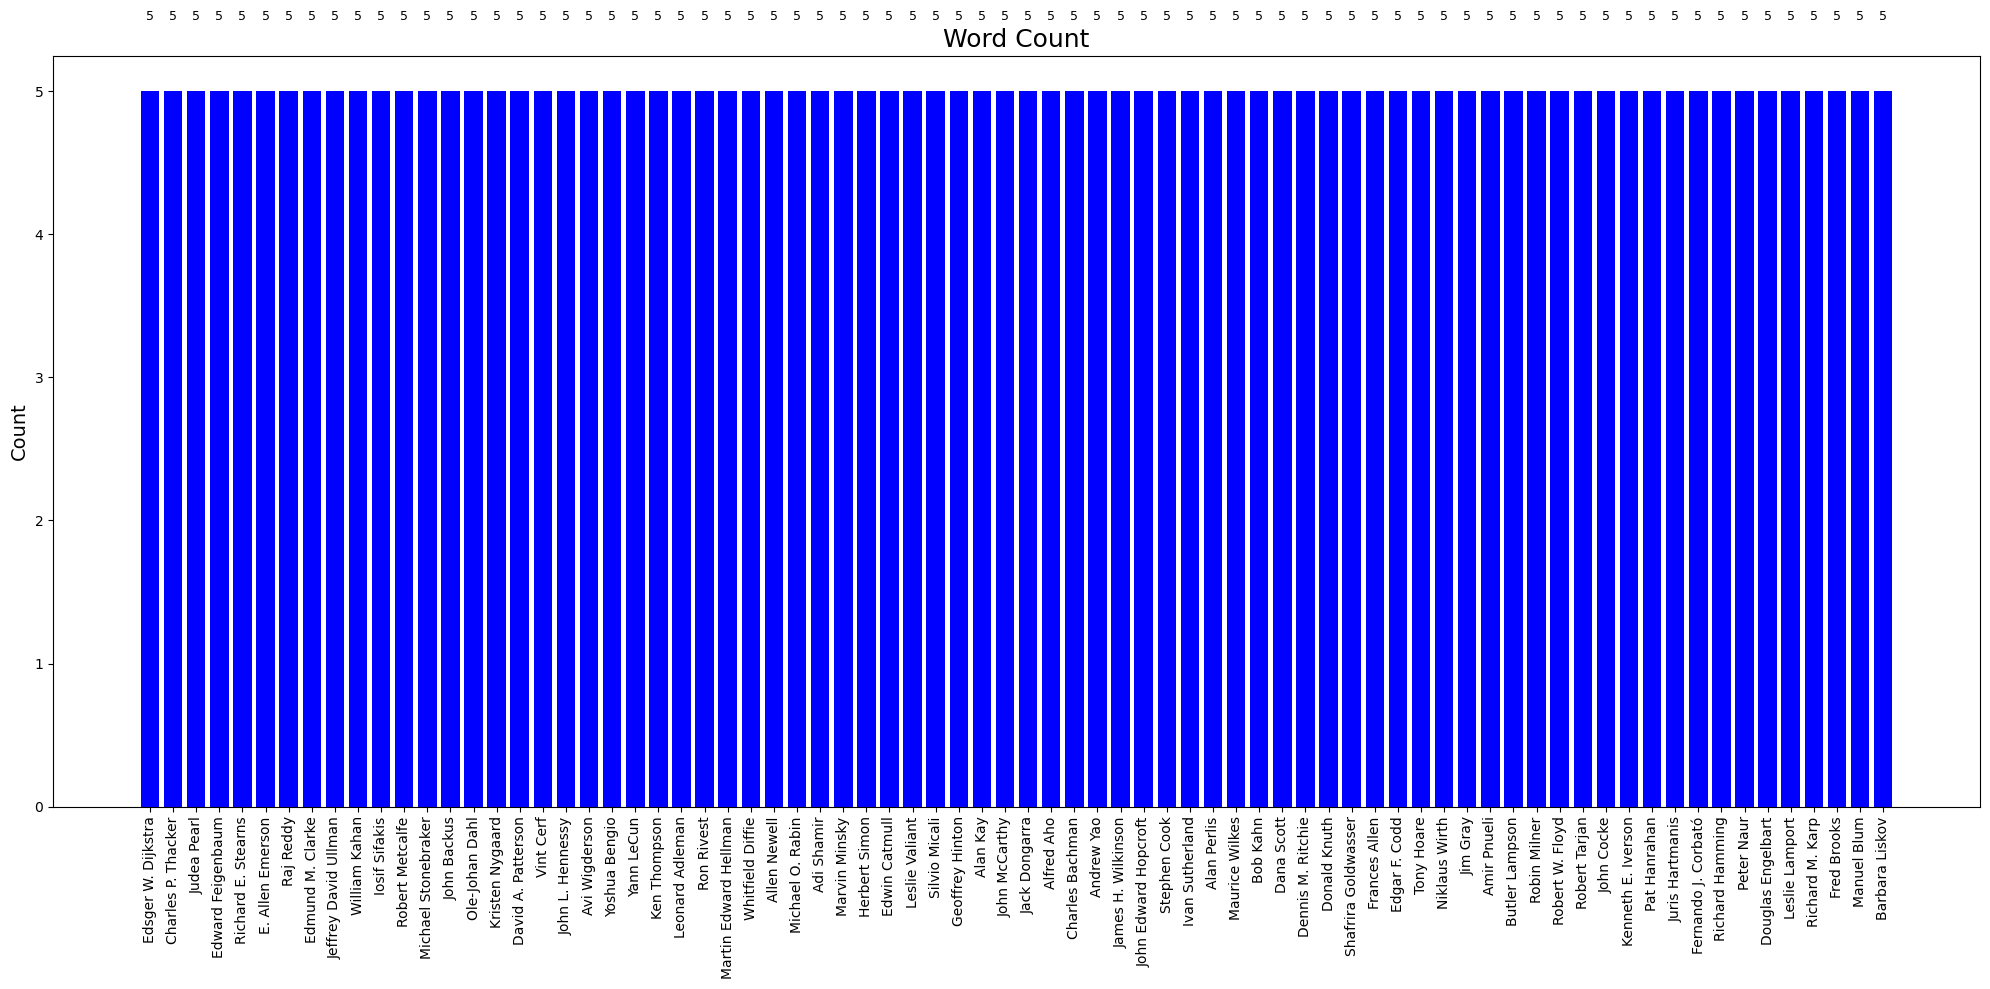

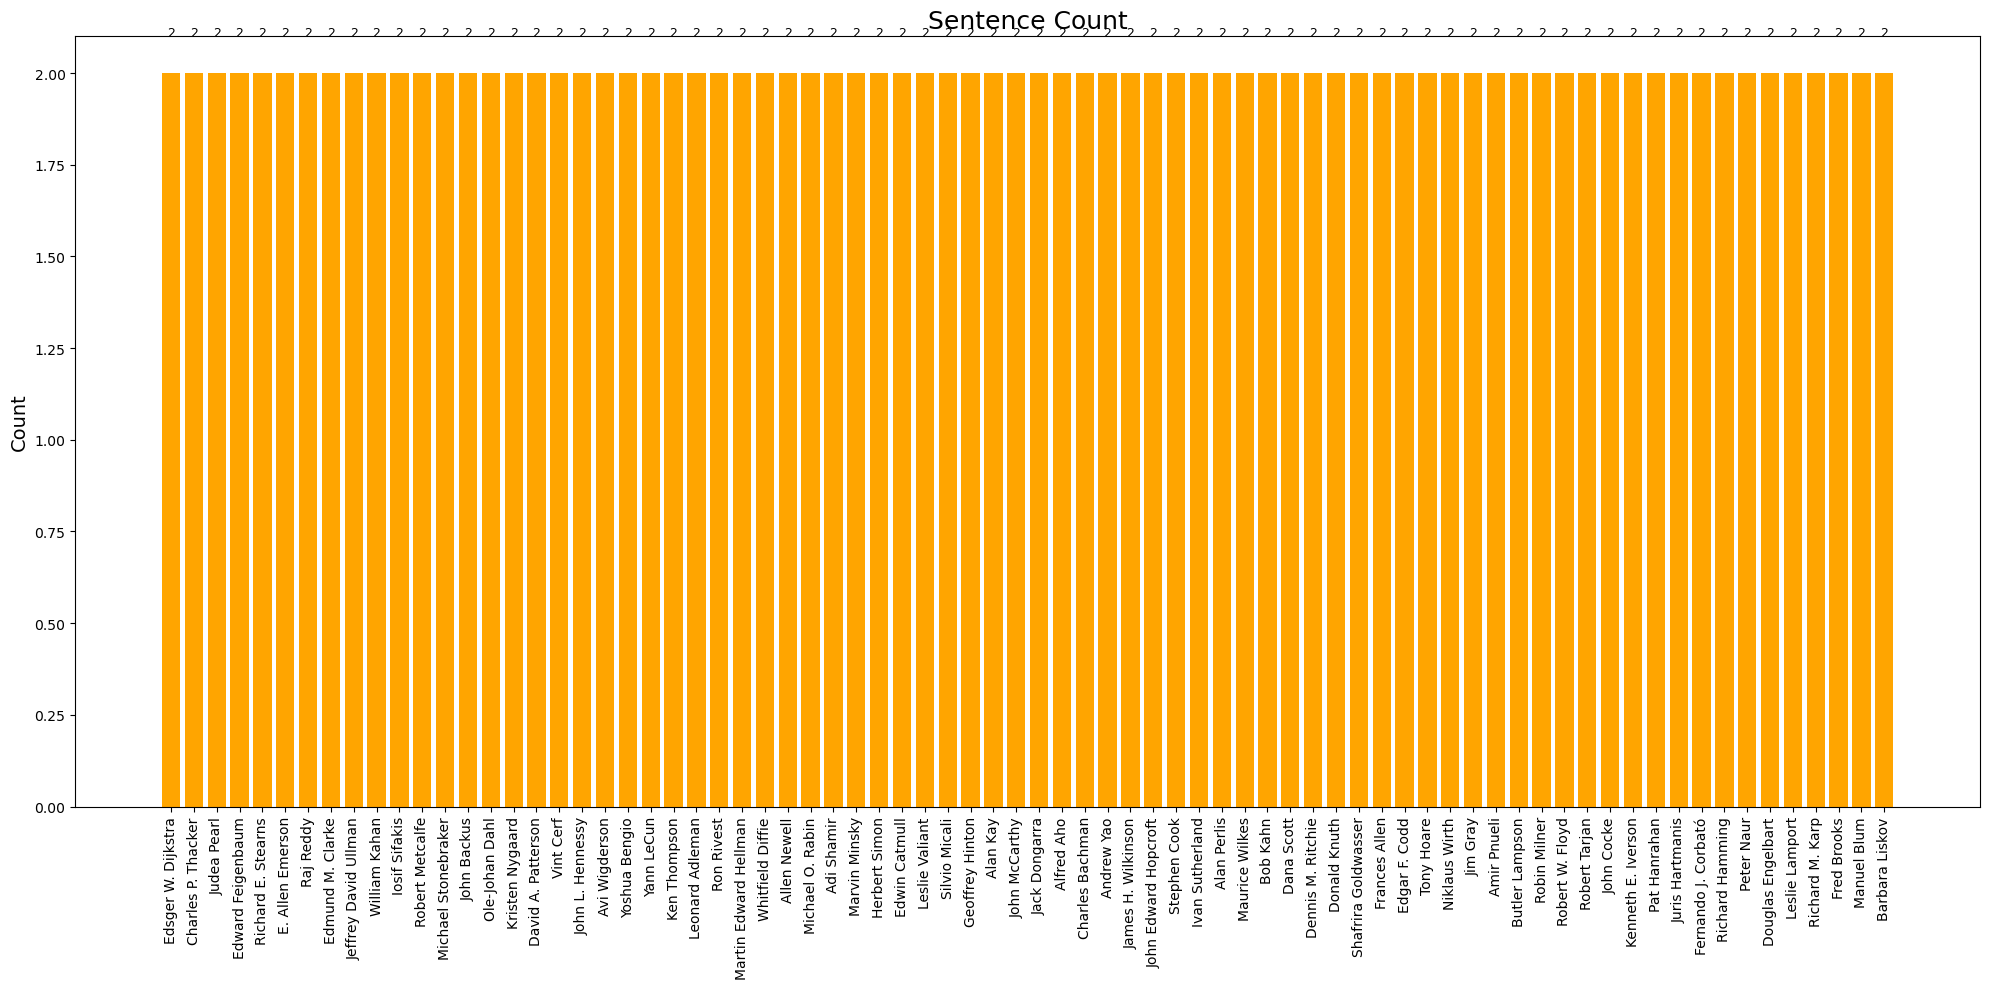

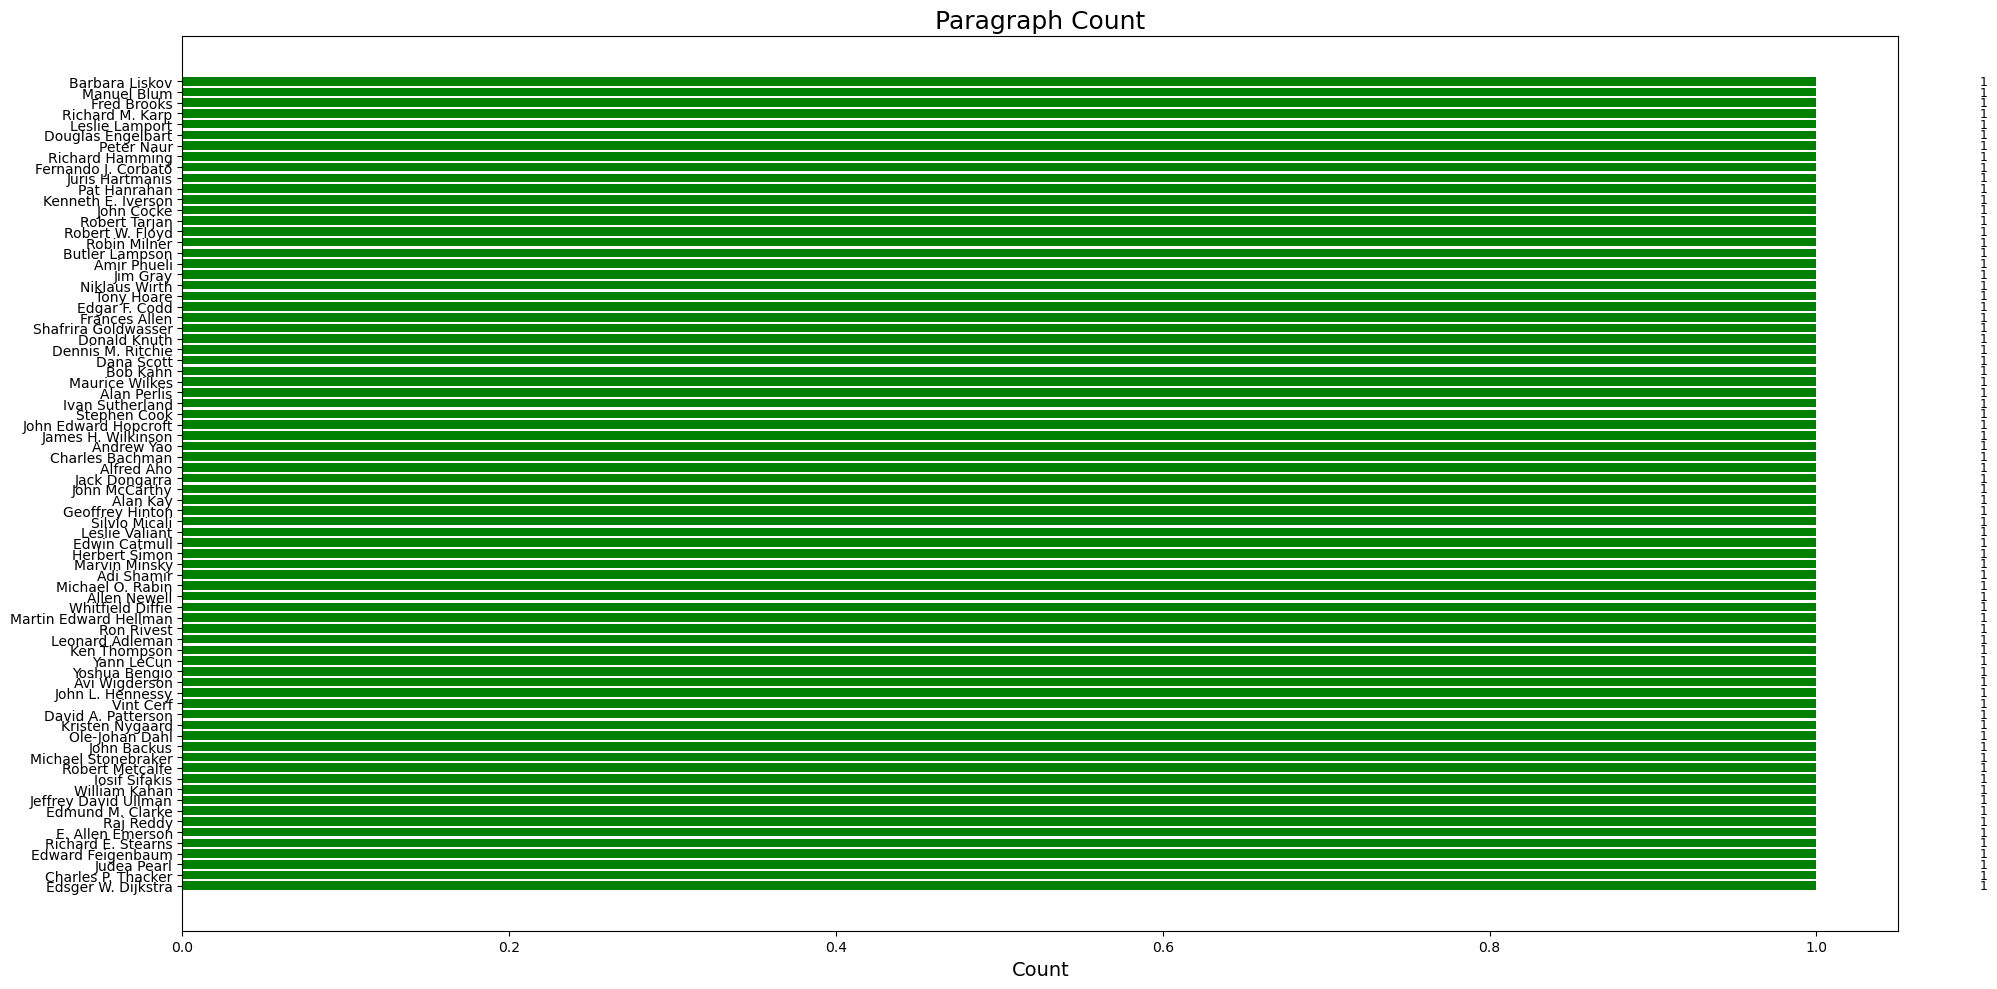

In [84]:
def plot_individual_statistics(df):
    """Improved visualization with separate figures for word, sentence, and paragraph counts."""
    if df.empty:
        print("Filtered DataFrame is empty. Ensure valid intro text is available.")
        return

    # Remove outliers for better visualization (e.g., top 95th percentile)
    word_count_threshold = df["word_count"].quantile(0.95)
    df = df[df["word_count"] <= word_count_threshold]

    # Word Count Plot
    plt.figure(figsize=(20, 10))  # Large figure size
    df_word = df.sort_values("word_count")
    plt.bar(df_word["name"], df_word["word_count"], color="blue")
    plt.title("Word Count", fontsize=18)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    for i, v in enumerate(df_word["word_count"]):
        plt.text(i, v + 0.5, str(v), ha="center", fontsize=9)
    plt.tight_layout()
    plt.show()

    # Sentence Count Plot
    plt.figure(figsize=(20, 10))  # Large figure size
    df_sentence = df.sort_values("sentence_count")
    plt.bar(df_sentence["name"], df_sentence["sentence_count"], color="orange")
    plt.title("Sentence Count", fontsize=18)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    for i, v in enumerate(df_sentence["sentence_count"]):
        plt.text(i, v + 0.1, str(v), ha="center", fontsize=9)
    plt.tight_layout()
    plt.show()

    # Paragraph Count Plot
    plt.figure(figsize=(20, 10))  # Large figure size
    df_paragraph = df.sort_values("paragraph_count")
    plt.barh(df_paragraph["name"], df_paragraph["paragraph_count"], color="green")
    plt.title("Paragraph Count", fontsize=18)
    plt.xlabel("Count", fontsize=14)
    plt.yticks(fontsize=10)
    for i, v in enumerate(df_paragraph["paragraph_count"]):
        plt.text(v + 0.1, i, str(v), va="center", fontsize=9)
    plt.tight_layout()
    plt.show()

# Apply the individual visualizations
plot_individual_statistics(award_winners_df)


This section provides an enhanced visualization of the text statistics for the top 20 Turing Award recipients based on their introduction text retrieved from Wikipedia.
The output is filtered to exclude rows with insufficient data (e.g., word counts ≤ 2) to ensure meaningful comparisons. The exact counts are displayed above each bar for clarity. This visualization provides an intuitive understanding of how the introduction texts vary in length and structure among the recipients.




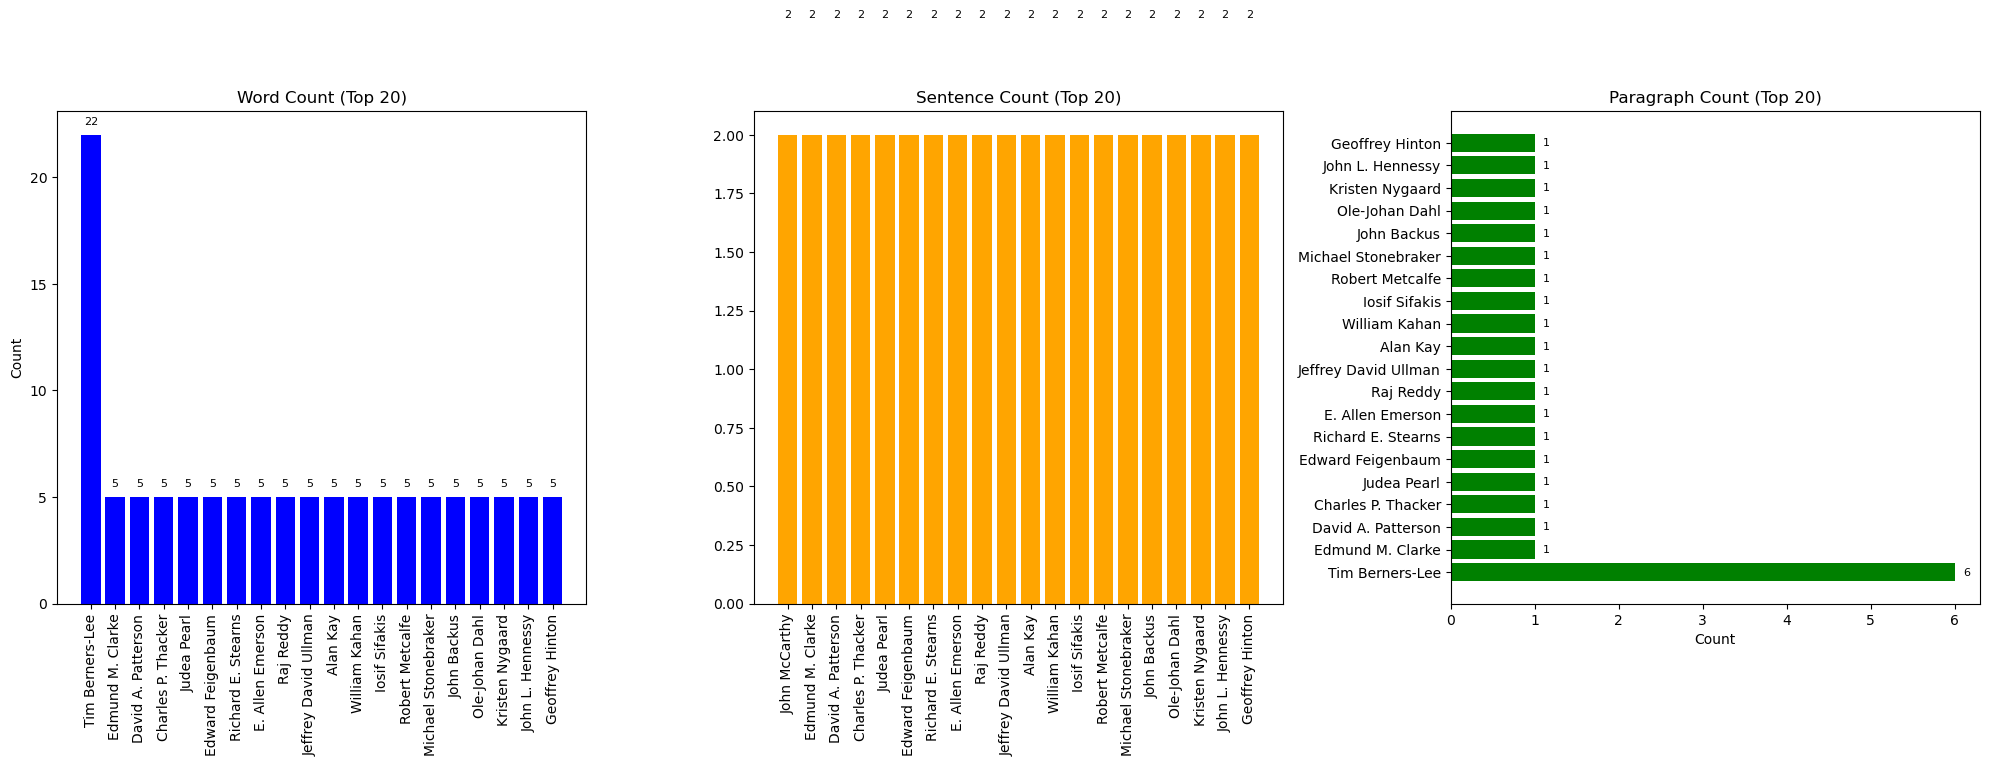

In [85]:
def plot_statistics(df):
    """Enhanced visualization for word, sentence, and paragraph counts."""
    if df.empty:
        print("Filtered DataFrame is empty. Ensure valid intro text is available.")
        return

    # Remove rows with minimal data for better insights
    df_filtered = df[df["word_count"] > 2]  # Example: Filter out rows with word count <= 2

    fig, ax = plt.subplots(1, 3, figsize=(20, 8))

    # Word Count
    df_word = df_filtered.sort_values("word_count", ascending=False).head(20)  # Top 20 entries
    ax[0].bar(df_word["name"], df_word["word_count"], color="blue")
    ax[0].set_title("Word Count (Top 20)")
    ax[0].set_ylabel("Count")
    ax[0].tick_params(axis="x", rotation=90)
    for i, v in enumerate(df_word["word_count"]):
        ax[0].text(i, v + 0.5, str(v), ha="center", fontsize=8)

    # Sentence Count
    df_sentence = df_filtered.sort_values("sentence_count", ascending=False).head(20)
    ax[1].bar(df_sentence["name"], df_sentence["sentence_count"], color="orange")
    ax[1].set_title("Sentence Count (Top 20)")
    ax[1].tick_params(axis="x", rotation=90)
    for i, v in enumerate(df_sentence["sentence_count"]):
        ax[1].text(i, v + 0.5, str(v), ha="center", fontsize=8)

    # Paragraph Count
    df_paragraph = df_filtered.sort_values("paragraph_count", ascending=False).head(20)
    ax[2].barh(df_paragraph["name"], df_paragraph["paragraph_count"], color="green")
    ax[2].set_title("Paragraph Count (Top 20)")
    ax[2].set_xlabel("Count")
    for i, v in enumerate(df_paragraph["paragraph_count"]):
        ax[2].text(v + 0.1, i, str(v), va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

# Apply the visualization
plot_statistics(award_winners_df)
